**Introduction**

In this data set we will be looking song database from Spotify. The data contains qualities of a song like accouticness, loudness, etc. starting from 1920 to 2020. 

The goal of this project is to create an unsupervised learning model that will bucketize this database into clusters, which ultimately can be used to recommend similar songs to the user.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.decomposition import PCA
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
import umap
import seaborn as sb
from sklearn import mixture

drive.mount('/content/drive')

In [ ]:
#load data
data = pd.read_csv('/content/drive/MyDrive/Thinkful Projects/Capstone III/data.csv')


In [ ]:
#simple initial data exploration
data.head(3)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


**Performing data exploration/visualization.**

[]

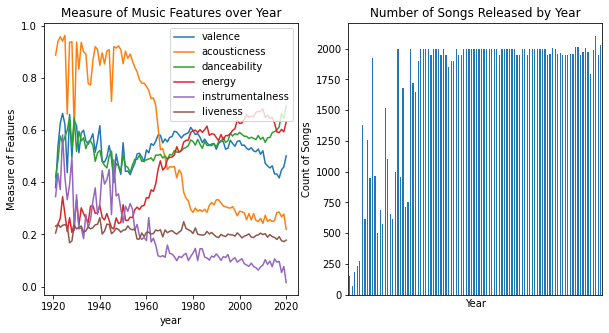

In [ ]:
#valence, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness
feature_plots = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness']
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#look at music over the years
data.groupby('year',as_index=False, sort=False).mean().plot(x = 'year', y = feature_plots, ax=axs[0])
axs[0].title.set_text('Measure of Music Features over Year')
axs[0].set(ylabel="Measure of Features")

#look at the distribution and representation of music over year
data.groupby('year',as_index=False, sort=False)['year'].size().plot(x = 'year', y = 'size',kind = 'bar',ax=axs[1])
axs[1].title.set_text('Number of Songs Released by Year')
axs[1].set(xlabel = 'Year', ylabel="Count of Songs")
axs[1].get_legend().remove()
axs[1].set_xticks([])


**Data wrangling: removing text strings and looking at correlations to reduce dimension.**

In [ ]:
#remove strings 'artists','id','name','release_date' columns
X = data.drop(columns = ['artists','id','name','release_date'])

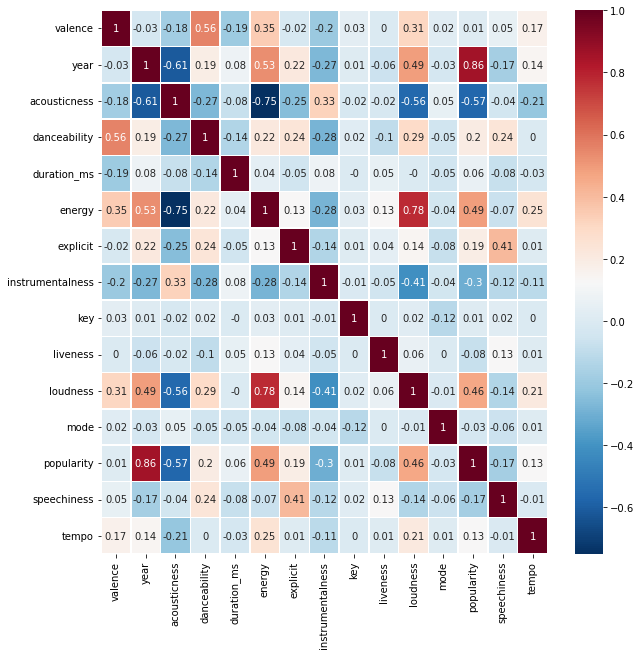

In [ ]:
#looking at correlation to remove dimensions
fig, ax = plt.subplots(figsize=(10, 10))

pearsoncorr = X.corr(method='pearson')
sb.heatmap(pearsoncorr.round(2), 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

Looking at the correlation matrix to remove highly correlated variables.

**Popularity and year** seems to be correlated but thats because we have more data as the years progress so we'll choose to keep these features.

**Energy and accouticness** are highly correlated but negatively correlated so we'll keep these features.

**Loudness and engery** are highly correlated and could be conveying the same information in a song. We'll remove loudness. 

In [ ]:
X = X.drop(columns = ['loudness'])

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
# initializing umap
dim_reduce = umap.UMAP()

# reducing data by umap
umap_dat = dim_reduce.fit_transform(X_std)

In [ ]:
#using pca to reduce dimension
pca_dat = PCA(n_components=2).fit_transform(X_std)

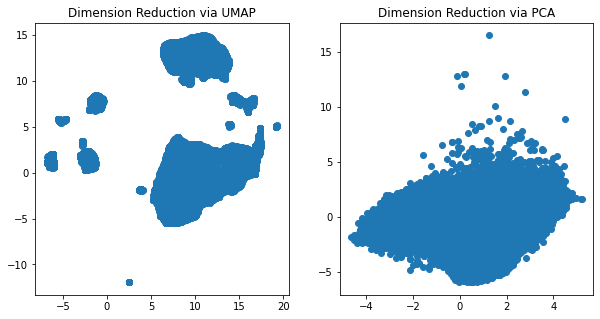

In [ ]:
#visualizing using UMAP and PCA
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

axs[0].scatter(umap_dat[:, 0], umap_dat[:,1])
axs[0].title.set_text('Dimension Reduction via UMAP')
axs[1].scatter(pca_dat[:, 0], pca_dat[:,1])
axs[1].title.set_text('Dimension Reduction via PCA')
plt.show()

Looking at the result of PCA and UMAP, we can see that dimensionality reduction process in UMAP was able to grab more distinct features/clusters with just 2 components. 

We will move forward with the data clustering using the UMAP data. 

**Implementing clustering with KMeans, GaussianMixture, and DBscan.**

We will start with DBscan since it does not require a known number of clusters.

In [ ]:
#Initialize DBSCAN
DB_pred = DBSCAN(eps=.5, min_samples=5, metric="euclidean").fit_predict(umap_dat)

#Note: eps = .5 was chosen to prevent crashing. DBscan crashes at eps = 1.

Text(0.5, 1.0, 'DBScan')

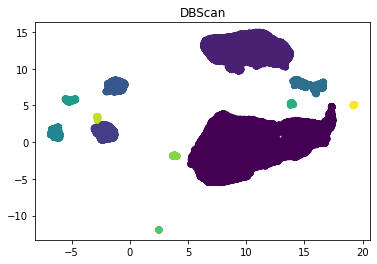

In [ ]:
plt.scatter(umap_dat[:, 0], umap_dat[:,1], c= DB_pred)
plt.title('DBScan')

In [ ]:
print('The Silhouette Score for DBScan is: ', metrics.silhouette_score(umap_dat, DB_pred, metric='euclidean'))

The Silhouette Score for DBScan is:  0.23644796


Using DBscan's clusters and UMAP's dimension reduction visualization we can estimate that there are roughly 11 clusters. 

We will run Kmeans and Gaussian Mixture for 10-12 clusters and compare results. 

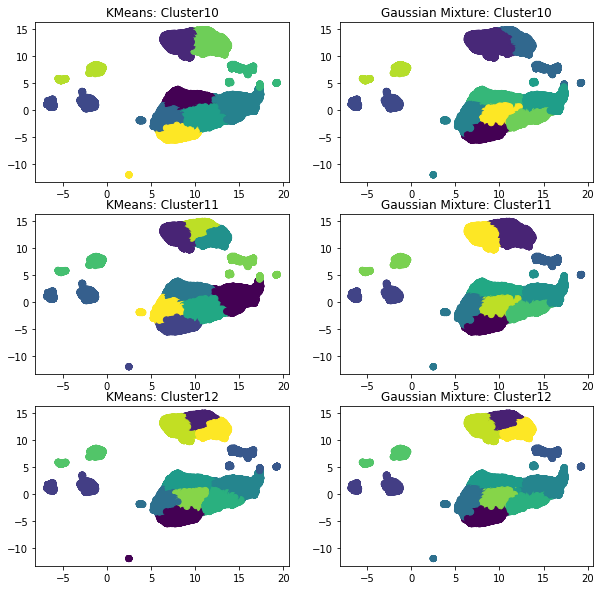

In [ ]:
#NOTE: this block of code can take up to 1hr to run. Comment out sil_scores 
#in for loop for faster run time. 

#create subplots to view results
fig, axs = plt.subplots(3, 2, figsize=(10, 10)) 

#create dataframe to store silhouette scores
sil_score = pd.DataFrame(columns=['Clusters','KMeans', 'GMM'])
sil_score['Clusters'] = [10,11,12]

for i in range(10,13):
  #run kMeans 
  KM_pred = KMeans(n_clusters=i, random_state=123).fit_predict(umap_dat)

  #run Gaussian Mixture 
  GMM_pred = mixture.GaussianMixture(n_components=i, random_state=123).fit_predict(umap_dat)

  #plot for each cluster
  axs[i-10,0].scatter(umap_dat[:, 0], umap_dat[:,1], c= KM_pred)
  axs[i-10,0].title.set_text('KMeans: Cluster'+ str(i))
  axs[i-10,1].scatter(umap_dat[:, 0], umap_dat[:,1], c= GMM_pred)
  axs[i-10,1].title.set_text('Gaussian Mixture: Cluster'+ str(i))

  #Comment out the two lines below to run code faster
  sil_score.iloc[i-10,1] =  metrics.silhouette_score(umap_dat, KM_pred, metric='euclidean')#kmeans sil score
  sil_score.iloc[i-10,2] =  metrics.silhouette_score(umap_dat, GMM_pred, metric='euclidean')#GMMM sil score


In [ ]:
#print sil_scores
sil_score.head()

,Clusters,KMeans,GMM
0,10,0.471086,0.439453
1,11,0.465085,0.450373
2,12,0.453839,0.448175


**Summary and Recommendation:** 

KMeans model was selected amongst 2 other models. It was able to cluster the song libraries into 10 different clusters with a silhouette score of 0.4711. 


The use of this tool can help Spotify create another way of recommending songs by giving them the ability to determine similar songs within the same clusters. 


Recommendations:
(1) Running the results with different number of components in UMAP to improve silhouette score if needed. (2) Using this tool in conjunction with a genre clustering to potentially give better song recommendations. 
